<a href="https://colab.research.google.com/github/sushmitharamk/computervision/blob/main/LENET5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUCTION**
LENET is the start of the complex architectures (came out in 1998).This architecture consists of seven layers.

*   3 Convolutional layers
*   2 Subsampling layers
*   2 fully linked layers


In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os
import time

from typing import Iterable, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets,transforms

# **1. LeNet5 Architecture**

In [24]:
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()

    self._body = nn.Sequential(

        ##First Convolutional Layer
        #input is (32 x 32) and output is (28 x 28)
        nn.Conv2d(in_channels= 1, out_channels= 6, kernel_size= 5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2),

        ##Second convolutional layer
        #input is (14 x 14), output size = (10 x 10)
        nn.Conv2d(in_channels = 6, out_channels=16, kernel_size=5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),
    )

    #Fully connected layers
    self._head = nn.Sequential(
        #first fully connected layers
        #in_features = total number of weights in last conv layer = 16 * 5 * 5
        nn.Linear(in_features=16 * 5 * 5, out_features=120),

        #ReLU activation
        nn.ReLU(inplace = True),

        #second  fully connected layer
        #in_features = output of last linear layer =120
        nn.Linear(in_features=120, out_features = 84),

        nn.ReLU(inplace =True),
        nn.Linear(in_features=84, out_features=10)
    )

  def forward(self,x):
    #apply feature extractor
    x = self._body(x)
    #flatten the output of conv layers
    #dimensions should be batch_size * number_of_weights_in_last_conv_layer
    x = x.view(x.size()[0],-1)
    #apply classification head
    x = self._head(x)
    return x

In [25]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


# **2. Get MNIST Data**

In [26]:
def get_data(batch_size, data_root ='data',num_workers =1):
  train_test_transforms = transforms.Compose([
      #resize to 32 * 32
      transforms.Resize((32,32)),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,),(0.3081,))
  ])

  # train dataloader
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST(root=data_root,train=True,download=True,transform=train_test_transforms),
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers
  )

  test_loader = torch.utils.data.DataLoader(
      datasets.MNIST(root=data_root, train =False, download = False, transform=train_test_transforms),
      batch_size = batch_size,
      shuffle =False,
      num_workers = num_workers
  )
  return train_loader, test_loader

# **3. System Configuration**

In [27]:
@dataclass
class SystemConfiguration:
  seed: int =42
  cudnn_benchmark_enabled: bool = True
  cudnn_deterministic: bool = True

# **4. Training Configuration**

In [28]:
@dataclass
class TrainingConfiguration:

  batch_size: int = 32 #amount of data to pass through the netwoek at each forward-backward iteration
  epochs_count: int = 20 #number of times the whole dataset will be passed through the network
  learning_rate: float = 0.01 #determines the speed of network's weight update
  log_interval: int = 100 # how many batches to wait between logging training status
  test_interval: int =1 # how many epochs to wait before another test. set 1 to get val loss of each epoch
  data_root:str  = "../resource/lib/publicdata/data" # folder to save MNIST data
  num_workers: int =10 # number of concurrent processes used to prepare data
  device: str='cuda'

# **5. System Setup**

In [29]:
def setup_system(system_config: SystemConfiguration) -> None:
  torch.manual_seed(system_config.seed)
  if torch.cuda.is_available():
    torch.backends.cudnn_benchmark_enabled= system_config.cudnn_benchmark_enabled
    torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# **6. Training**

Training pipeline used in PyTorch is as follows.

1. send the data to the required device (GPU).
2. Make a forward pass using the forward method.
3. find the loss using the Cross_entropy function
4. find the gradients using the backward function.
5. Update the weights using the optimiser.
6. find the accuracy of the model.


In [30]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader : torch.utils.data.DataLoader, epoch_idx: int
) -> Tuple[float,float]:

    model.train()
    batch_loss = np.array([])
    batch_acc = np.array([])
    for batch_idx, (data, target) in enumerate(train_loader):

      indx_target = target.clone()
      data = data.to(train_config.device)
      target = target.to(train_config.device)

      optimizer.zero_grad()

      output = model(data)

      loss = F.cross_entropy(output,target)

      loss.backward()
      optimizer.step()

      batch_loss = np.append(batch_loss, [loss.item()])

      prob = F.softmax(output,dim=1)
      pred = prob.data.max(dim=1)[1]

      correct = pred.cpu().eq(indx_target).sum()

      acc = float(correct) / float(len(data))

      batch_acc = np.append(batch_acc,[acc])

      if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
        print(
            'Train Epoch: {} [{}/{}] Loss {:.6f} Acc: {:.4f}'.format(
                epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
            )
        )

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

# **7. Testing**

In [36]:
def test(
    train_config : TrainingConfiguration,
    model:nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    count_correct_predictions = 0

    with torch.no_grad():
      for data,target in test_loader:
        indx_target = target.clone()

        #send the data and target to the device/system settings
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        output = model(data)
        test_loss += F.cross_entropy(output,target).item()
        prob = F.softmax(output, dim =1)
        pred = prob.data.max(dim=1)[1]

        count_correct_predictions += pred.cpu().eq(indx_target).sum()

      test_loss = test_loss / len(test_loader)

      accuracy = 100. * count_correct_predictions / len(test_loader.dataset)

      print(
          '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              test_loss, count_correct_predictions, len(test_loader.dataset), accuracy
          )
      )
    return test_loss, accuracy/100.0


# **8. Main**

this section is use the configuration and start the training.

1. Set up system parameters like CPU/GPU, number of threads etc.
2. load the data using dataloaders
3. create an instance of the LeNet model.
4. Specify optimizer to use.
5. set up variables to track loss and accuracy and start training.

In [37]:
def main(system_configuration = SystemConfiguration(), training_configuration = TrainingConfiguration()) :

  # system configuration
  setup_system(system_configuration)

  #batch size
  batch_size_to_set = training_configuration.batch_size
  #num_workers
  num_workers_to_set = training_configuration.num_workers
  #epochs
  epoch_num_to_set =  training_configuration.epochs_count

  #############Setting up system parameter#############

  if torch.cuda.is_available():
    device = "cuda"
  else:
    device = "cpu"
    batch_size_to_set = 16
    num_workers_to_set = 2
    epochs_num_to_set = 5

################ Load the data with dataloaders ##############

    train_loader, test_loader = get_data(
        batch_size = batch_size_to_set,
        data_root = training_configuration.data_root,
        num_workers = num_workers_to_set
    )

    #update training configuration
    training_configuration = TrainingConfiguration(
        device = device,
        epochs_count = epoch_num_to_set,
        batch_size= batch_size_to_set,
        num_workers= num_workers_to_set
    )

############### Instance of Network #################

    #intiate model
    model = LeNet5()

    # send model to device
    model.to(training_configuration.device)

    #optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = training_configuration.learning_rate
    )
    best_loss = torch.tensor(np.inf)

    #epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    #epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    #training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

      train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)

      epoch_train_loss = np.append(epoch_train_loss, [train_loss])

      epoch_train_acc = np.append(epoch_train_acc, [train_acc])

      elapsed_time = time.time() - t_begin
      speed_epoch = elapsed_time / (epoch + 1)
      speed_batch = speed_epoch / len(train_loader)
      eta = speed_epoch * training_configuration.epochs_count - elapsed_time

      print(
          "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
              elapsed_time, speed_epoch, speed_batch, eta
          )
      )

      if epoch % training_configuration.test_interval == 0:
        current_loss, current_accuracy = test(training_configuration, model, test_loader)

        epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        epoch_test_acc = np.append(epoch_test_acc,[current_accuracy])

        if current_loss < best_loss:
          best_loss = current_loss

    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [38]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Train Epoch: 0 [1600/60000] Loss 2.304386 Acc: 0.0625
Train Epoch: 0 [3200/60000] Loss 2.020136 Acc: 0.3750
Train Epoch: 0 [4800/60000] Loss 0.966735 Acc: 0.6250
Train Epoch: 0 [6400/60000] Loss 1.003069 Acc: 0.5625
Train Epoch: 0 [8000/60000] Loss 1.318518 Acc: 0.6875
Train Epoch: 0 [9600/60000] Loss 0.402901 Acc: 0.8125
Train Epoch: 0 [11200/60000] Loss 0.196657 Acc: 1.0000
Train Epoch: 0 [12800/60000] Loss 0.104711 Acc: 1.0000
Train Epoch: 0 [14400/60000] Loss 0.796018 Acc: 0.7500
Train Epoch: 0 [16000/60000] Loss 0.345478 Acc: 0.8750
Train Epoch: 0 [17600/60000] Loss 0.345221 Acc: 0.8750
Train Epoch: 0 [19200/60000] Loss 0.066517 Acc: 1.0000
Train Epoch: 0 [20800/60000] Loss 0.303622 Acc: 0.8750
Train Epoch: 0 [22400/60000] Loss 0.713501 Acc: 0.8750
Train Epoch: 0 [24000/60000] Loss 0.120694 Acc: 0.9375
Train Epoch: 0 [25600/60000] Loss 0.173603 Acc: 0.9375
Train Epoch: 0 [27200/60000] Loss 0.154132 Acc: 0.8750
Train Epoch: 0 [28800/60000] Loss 0.264477 Acc: 0.8750
Train Epoch: 0 [

# **9.Plot Loss**

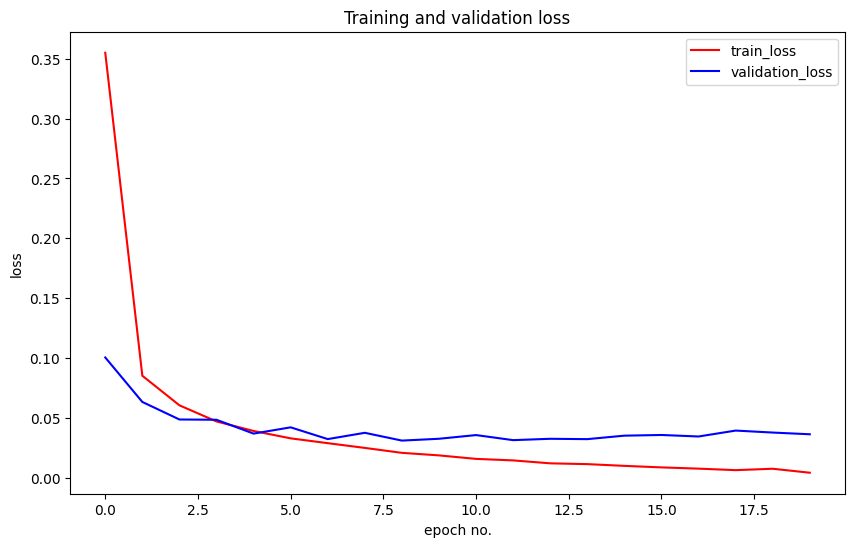

In [39]:
plt.rcParams["figure.figsize"] = (10,6)
x = range(len(epoch_train_loss))

plt.figure
plt.plot(x, epoch_train_loss, color='r', label = "train_loss")
plt.plot(x, epoch_test_loss, color ='b', label="validation_loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.show()

# **10. Plot Accuracy**

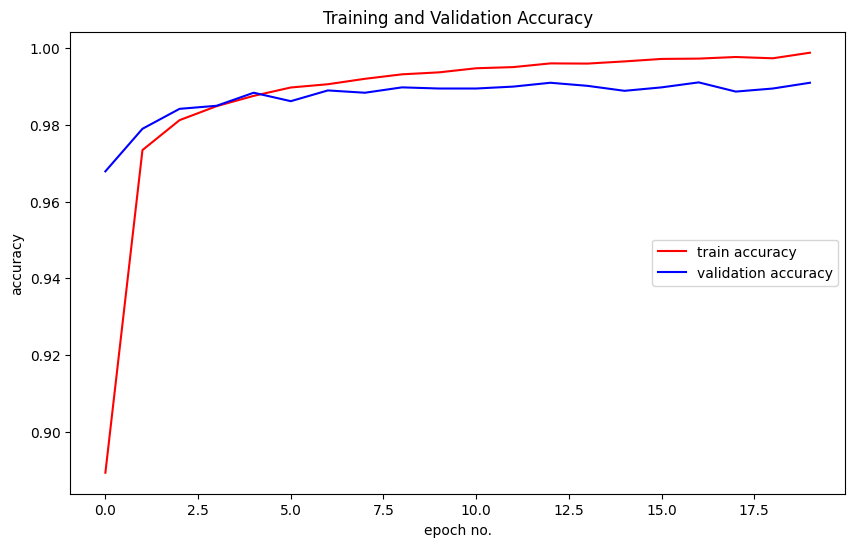

In [40]:
plt.rcParams["figure.figsize"] = (10,6)
x = range(len(epoch_train_loss))

plt.figure
plt.plot(x, epoch_train_acc, color ='r', label = "train accuracy")
plt.plot(x, epoch_test_acc, color = 'b', label = "validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc = 'center right')
plt.title('Training and Validation Accuracy')
plt.show()


# **11. Save the Model Parameters**

In [42]:
models = 'models'
if not os.path.exists(models):
  os.makedirs(models)

model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

model.to('cpu')

torch.save(model.state_dict(),model_path)

# **12. Load the Model Parameters**

Saving the model parameters can help to load the parameters into model using similar functions.

1. Create an instance of the model class.
2. Load the parameters by using torch.load(model_path).
3. Load the parameters inside the model using model.load_state_dict().

In [43]:
#initiate the model
lenet5_mnist = LeNet5()

# Loading the model and getting model parameters by using load_state_dict
lenet5_mnist.load_state_dict(torch.load(model_path))

<ipython-input-43-d40a89577a4d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet5_mnist.load_state_dict(torch.load(model_path))


<All keys matched successfully>

# **13. Model Prediction**

In [44]:
def prediction(model, train_config, batch_input):
  with torch.no_grad():
    model.to(train_config.device)
    model.eval()
    data = batch_input.to(train_config.device)
    output = model(data)

    prob = F.softmax(output, dim = 1)
    pred_prob = prob.data.max(dim=1)[0]
    pred_index = prob.data.max(dim=1)[1]

  return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

# **14. Run Inference on Sample Images**

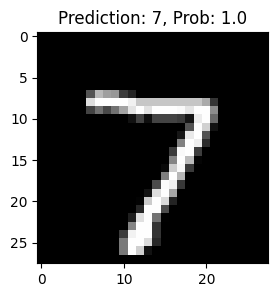

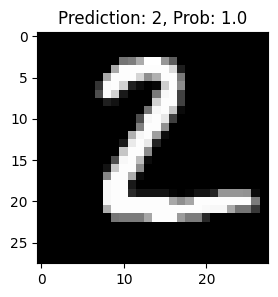

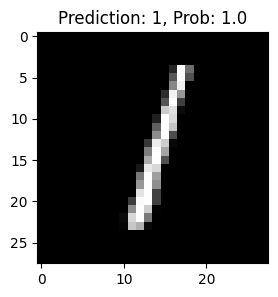

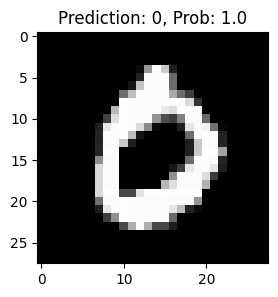

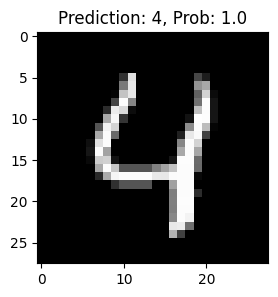

In [50]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
  train_config.device = "cuda"
else:
  train_config.device = "cpu"

#load test data without image transformation
test = torch.utils.data.DataLoader(
    datasets.MNIST(root = train_config.data_root, train=False, download = True,
                   transform = transforms.functional.to_tensor),
    batch_size = batch_size,
    shuffle =False,
    num_workers = 1
)

image_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root = train_config.data_root, train = False, download = True, transform = image_transforms),
                   batch_size = batch_size,
                   shuffle = False,
                   num_workers = 1
)


for data, _ in test_trans:
  pred, prob = prediction(lenet5_mnist, train_config, data)
  break

plt.rcParams["figure.figsize"] = (3,3)
for images, _ in test:
  for i, img in enumerate(images):
    img = transforms.functional.to_pil_image(img)
    plt.imshow(img, cmap='gray')
    plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
    plt.show()
  break